### Загрузка метрик

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime as dt
import json
import os

In [30]:
SCORE_PATH = "scores"
os.listdir(SCORE_PATH)

['pns10_bilstm_max.json',
 'pns50.json',
 'pns20_bilstm_max.json',
 'pns10.json',
 'pns20_attention.json',
 'pns20_bilstm.json',
 'pns50_bilstm.json',
 'pns5_2d_attention.json',
 'pns20_2d_attention.json',
 'pns50_attention.json',
 'pns10_2d_attention.json',
 'pns10_attention.json',
 'pns50_bilstm_max.json',
 'pns5_attention.json',
 'pns5_bilstm.json',
 'pns5_bilstm_max.json',
 'pns20.json',
 'pns5.json',
 'pns10_bilstm.json',
 'pns50_2d_attention.json']

In [27]:
for subdir in os.listdir(SCORE_PATH):
    with open(f"{SCORE_PATH}/{filename}", "r") as file:  
        variable_name = filename.split('.')[0]
        exec(f"{variable_name} = {json.load(file)}")

In [31]:
pns5['TSAG-PNMLSTM-PNS5-EC50-BS10K-PCL25-PCLS0'][:2]

[{'roc_auc_score_test': 0.9301214812625718,
  'roc_auc_score_display': 0.9281200409810899,
  'loss': 0.1707544082345871,
  'iteration': 0,
  'timestamp': '2022-10-07 20:57:47.383679'},
 {'roc_auc_score_test': 0.9753508019965788,
  'roc_auc_score_display': 0.9733126506670918,
  'loss': 0.08562425583457718,
  'iteration': 1,
  'timestamp': '2022-10-07 20:59:44.425580'}]

### Воспроизведение результата

Обучил ```LSTM``` для размеров ```PNS``` = $[5, 10, 20, 50]$ на датасете ```big``` с параметрами:
* ```EC50``` количество эпох
* ```BS10K``` размер батча
* ```PCL25``` размер контекста
* ```PCLS``` = $[0, 0.15, 0.25, 0.5]$ доля правого контекста

Обучение проходило в облаке на четырех инстансах (для каждого ```PNS```) с ресурсами ```vCPU = 2```, ```RAM = 16GB``` и заняло:

In [32]:
def hours_for_training(pns, mask = '%Y-%m-%d %H:%M:%S.%f'):
    job_ids = list(pns.keys())
    
    cvt_to_time = lambda x: dt.strptime(x, mask)
    
    return {
        job_id: (
            cvt_to_time(pns[job_id][-1]['timestamp']) - \
            cvt_to_time(pns[job_id][0]['timestamp'])
        ).
        total_seconds() / 3600
        for job_id in job_ids
    }

In [33]:
def plot_hours_for_training(pns_list, pns_labels):
    fig, ax = plt.subplots(figsize=(6, 4))

    pcls = ['0', '0.15', '0.25', '0.5']
    ax.set_xticks(range(len(pcls)))
    ax.set_xticklabels(pcls)
    ax.set_xlabel('PCLS', fontsize=12)

    ax.set_ylabel('Hours', fontsize=12)
    ax.set_title('Hours for training', fontsize=12)

    for i in range(len(pns_list)):
        pns_hours = hours_for_training(pns_list[i])
        ax.plot(
            pcls, list(pns_hours.values()), 
            marker='o', label=pns_labels[i]
        )

    ax.grid(); ax.legend(); plt.show()

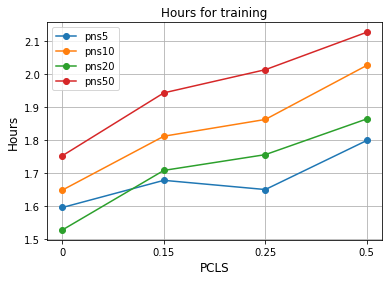

In [34]:
plot_hours_for_training([pns5, pns10, pns20, pns50], ['pns5', 'pns10', 'pns20', 'pns50'])

Размер контекста всегда одинаковый ```PCL``` $ = 25 $, но чем больше доля правого контекста тем больше времени уходит на обучение. Контринтуитивное наблюдение, возможно, просто случайность. Теперь посмотрим на метрики:

In [35]:
def plot_roc_auc_score(pns_list, pns_labels):

    fig, axes = plt.subplots(2, 2, figsize=(10,5))
    pcls = ['0', '0.15', '0.25', '0.5']

    def plot_one_pns(ax, pns):
        job_ids = list(pns.keys())
        for i, job_id in enumerate(job_ids):
            df = pd.DataFrame(pns[job_id]).set_index('iteration')
            ax.plot(df.index, df.roc_auc_score_test, label=pcls[i])
        ax.legend()

    for i in range(len(pns_list)):
        plot_one_pns(axes[i//2][i%2], pns_list[i])
        axes[i//2][i%2].set_title(pns_labels[i])

    fig.tight_layout()
    plt.show()

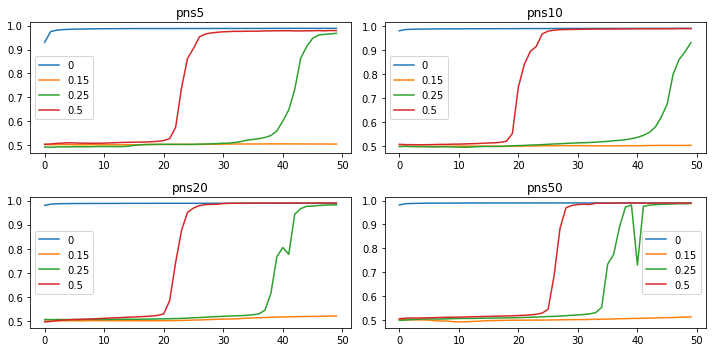

In [36]:
plot_roc_auc_score([pns5, pns10, pns20, pns50], ['pns5', 'pns10', 'pns20', 'pns50'])

Наблюдаемые дефекты:

* Медленная сходимость при включении правого контекста, при этом отсутствует зависимость между ```PCLS``` и скоростью сходимости (чем больше правый контекст тем медленнее сходимость)

* Обучение в минус

Помимо этого модель с параметром ```PLS015``` за ```50``` эпох не сходится, но растет, наверно я взял какие-то другие параметы, но в целом похоже.

Обучение ставил на ночь, утром обычные лстмки закончили обучение, сетки с ```attention``` завершили примерно половину, т.е. обычные лстмки обучаются примерно в ```2``` раза быстрее, но гипотеза была про другое.

###  Помогает ли attention убрать дефекты при смещенном контексте?

Речь идет [про трехмерный](https://arxiv.org/abs/1706.03762) ```attention```, который не понижает размерность входящего тензора, а работает в паре с рекуррентными сетями, например, с ```LSTM```, которая понизит размерность самостоятельно. Задача такого ```attention``` состоит в том, чтобы посмотреть на каждый батч отдельно и выделить отношения между контекстными векторами внутри этого батча. Идея в том, чтобы для каждого конкретного вектора не основываться только на следующих векторах, а посмотреть на все окружение целиком.

Подробно про то как строится такой механизм можно прочитать [здесь](https://jalammar.github.io/illustrated-transformer/) в секции про ```attention```. В коде матрицы весов удобно реализовывать с помощью слоев ```Linear(n_feautes, n_features)```.

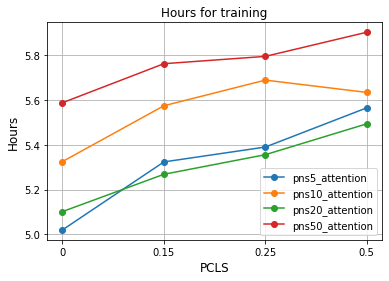

In [37]:
plot_hours_for_training([pns5_attention, pns10_attention, pns20_attention, pns50_attention], 
                        ['pns5_attention', 'pns10_attention', 'pns20_attention', 'pns50_attention']
)

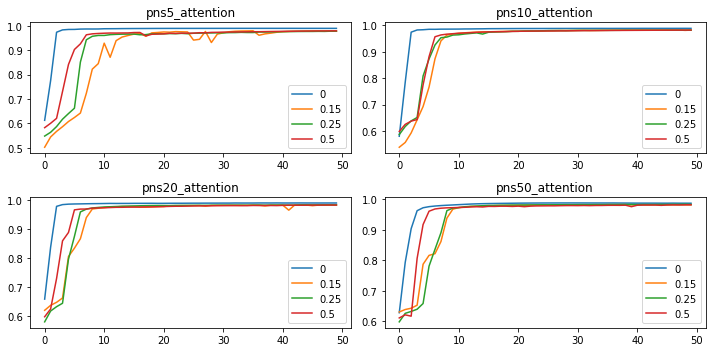

In [39]:
plot_roc_auc_score([pns5_attention, pns10_attention, pns20_attention, pns50_attention], 
                   ['pns5_attention', 'pns10_attention', 'pns20_attention', 'pns50_attention']
)

Из графиков видно, что сходимость для моделей с правым контекстом начинается примерно в одно и то же время на раннем этапе. Дефект медленной сходимости исчезает и нейросеть с ```attention``` начинает сходиться намного эпох быстрее чем обычная ```LSTM```, но вопрос здесь такой: 

*Нам есть куда торопиться?* Ведь в конце концов и обычная лстмка сойдется, при этом ее архитектура проще, и для завершения полного цикла обучения ей нужно в два раза меньше времени. Помимо этого:
* Дефект с обучением в минус остается, а это значит что модель может повести себя нестабильно на каком-то этапе обучения и уменьшить количество эпох будет плохой идеей. Особенно неприятно видеть это на графике ```pns5_attention```, очень много колебаний. Правый контекст важен и использовать только левый будет неправильно.


* Зависимость между долей правого контекста и скоростью сходимости по-прежнему не наблюдается. Интуитивно хочется так: чем больше правый контекст тем медленнее сходимость


* В среднем ```LSTM``` с ```attention``` нужно примерно $5$ часов чтобы обучиться полностью, а значит чтобы закончить даже $20$ эпох (к этому моменту скор будет более менее стабильно максимальный) ей нужно около двух часов. За это время обычная ```LSTM``` уже полностью обучится и получит результат не хуже.

Вывод: ```attention``` для реккурентной сети (есть еще плоский) не помогает устранить наблюдаемые дефекты полностью, при этом усложняет архитектуру сети. При его использовании нет очевидного преимущества, где бы можно было выиграть существенно по времени или по качеству обучения. Поэтому я бы не стал использовать ```attention``` в дополнении к обычной ```LSTM```.

### Плоский attention

Взвешивает контекстные вектора и понижает размерность, действует самостоятельно, без реккурентных сетей. То есть, если на входе есть ```context_length, batch_size, n_features```, то на выходе будет ```batch_size, n_features```. Реализуется довольно просто:

Если $c_1, c_2, \ldots c_n$ это контекстные вектора одного батча, а $c_i$ имеет размерность $m$, то давайте прогоним каждый такой вектор через линейный слой ```Linear(m, 1)``` и получим одномерный вектор весов размерностью контекста. Останется добавить нормализацию и сложить взвешенные вектора.

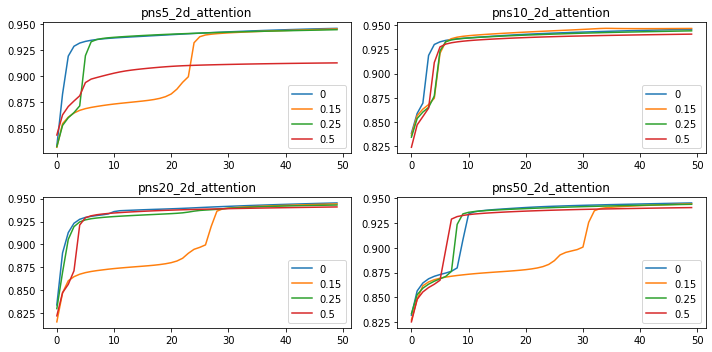

In [7]:
plot_roc_auc_score([pns5_2d_attention, pns10_2d_attention, pns20_2d_attention, pns50_2d_attention], 
                   ['pns5_2d_attention', 'pns10_2d_attention', 'pns20_2d_attention', 'pns50_2d_attention']
)

Плоский ```attention``` без ```LSTM``` не дает высоко похожий результат, максимальный скор ```0.95```. Помимо этого нет никаких зависимостей скорости сходимости от доли правого контекста (скорость сходимости в целом стала меньше), единственное преимущество то, что нет обучения в минус.

Вывод: может использоваться наравне с обычными плоскими сетями.

В рамках темы про ```attention``` можно еще порассуждать про ```multiattention```, который будет иметь несколько представлений, то есть просто несколько матриц весов или несколько векторов весов. В трехмерном случае решил не проверять эту идею, потому что даже с одним представлением обучение идет очень долго. Для плоского случая интуитивно не вижу в чем это может быть полезно.

### Двунаправленный LSTM

Еще один способ посмотреть на контекст не только в одном направлении. Прикручивать к такой модели трехмерный ```attention``` было бы неоправданно, потому что кажется что они бы дублировали друг друга (двунаправленный ```LSTM``` и сам может посмотреть назад), поэтому такая сетка будет расмматриваться сама по себе, при ее обучении есть важные моменты которые стоит обсудить.

И в ```LSTM```, и в ```LSTM``` с ```attention``` присутствует странное поведение сети при разной доли правого контекста. Правый контекст действительно важен, но не так, как левый, предположим, что вероятнее попасть в ситуацию когда выбор будет основываться только на левом контексте. И когда во время обучения модель накапливает информацию слева-направо, правая неключевая часть в большинстве случаев может сбивать с толку, и чем ее доля больше, тем неопределеннее будет ситуация, потому что за бóльшее количество итераций скрытое состояние изменится сильнее. В случаях, когда правая часть ключевая, последние итерации на реккурентном слое будут именно по ней, и если слева все было плохо, то правой частью все пофиксится. На то, чтобы адаптироваться к такому режиму (при наличии неключевой правой части отдавать предпочтение левой), модели нужно больше времени, поэтому, предполагаю, существует дефект меделенной сходимости, по этой же причине может возникать обучение в минус. Поэтому нужно как-то учитывать не только стратегию слева-направо, но и наоборот. Сделать это можно заменой обычной ```LSTM``` на двунаправленную. В коде поменяется лишь несколько строк, такое решение не усложняет архитектуру, в отличие от ```attention```.

Если предположение про важность левого и правого контекста не верное, то возникает зеркальная ситуация и можно провести аналогичные рассуждения. Все рассуждения выше субъективные, основываются на том, как я прочувствовал ситуацию, поэтому нет никаких гарантий.

<img src="images/bilstm.png" />

В чем идея?

Будем двигаться в обоих направлениях, и в конечном итоге на выходе получим два скрытых состояния. Первое будет отвечать за ```forward flow```, второе за ```backward flow```. Ключевым является ответ на вопрос: что делать с двумя состояниями? Когда было одно, мы его просто возвращали. Теперь можно по-разному аггрегировать, например, взять сумму, среднее, минимум, максимум, или вообще добавить плоский ```attention``` на выход. Кажется имеет смысл взять максимум или добавить ```attention```, чтобы приоритезировать наиболее важные фичи из векторов скрытого состояния. Однако, изначально я про это не подумал и запустил для среднего, что, кажется, реально не имеет смысла, потому что, например, если есть фичи для левого $90$ и для правого $1$, то среднее будет $45.5$, это сильно размазывает важность одной из них.

### Результаты для слияния по среднему

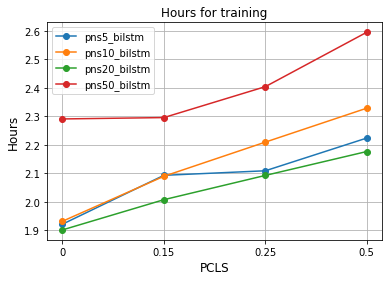

In [40]:
plot_hours_for_training([pns5_bilstm, pns10_bilstm, pns20_bilstm, pns50_bilstm], 
                        ['pns5_bilstm', 'pns10_bilstm', 'pns20_bilstm', 'pns50_bilstm']
)

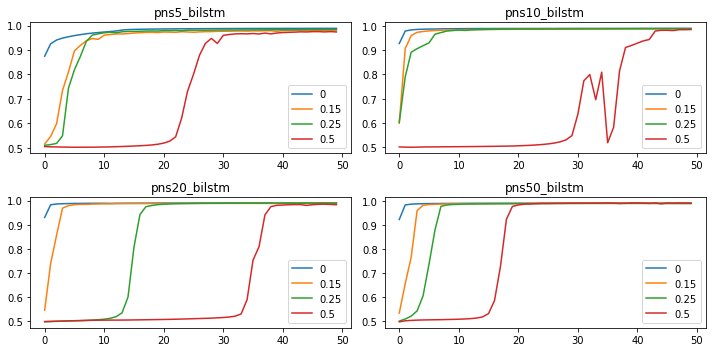

In [42]:
plot_roc_auc_score([pns5_bilstm, pns10_bilstm, pns20_bilstm, pns50_bilstm], 
                   ['pns5_bilstm', 'pns10_bilstm', 'pns20_bilstm', 'pns50_bilstm']
)

Исчезает дефект, при котором нет зависимости между ```PCLS``` и скоростью обучения. Теперь в каждом случае все по порядку, сначала $0$, затем $0.15$, затем $0.25$ и потом уже $0.5$. То есть, в двунаправленной лстмке соблюдается порядок, но есть обучение в минус для моделей с ```PCLS``` $ = 0.5 $. Модели с ```PCLS``` $ = 0.5 $ сильно испортили здесь картину, без них все дефекты можно было бы считать устраненными: и скорость сходимости стала приемлемая, и не было бы обучения в минус. Но есть то что есть. Это дает повод немного подумать над моделями с ```PCLS``` $ = 0.5 $

* Первое предположение. Такие модели можно пофиксить если взять аггрегацию, например, максимумом, потому что в них равноправное влияние не может уйти за счет среднего, пример есть выше. А максимум бы подчеркнул важность одного из контекстов.


* Второе предположение. Если доли левого и правого контекста равны, то такие модели вообще не имеют смысла в ```LSTM```. В том смысле, что ведут себя довольно непредсказуемо, поэтому доверие к ним невысокое. Как проверить не знаю, но все идеи которые возникали не смогли полностью пофиксить эту ситуацию, есть очень близкое, но все равно не полное.

### Аггрегация по максимуму в двунаправленном LSTM

Проверяем первое предположение

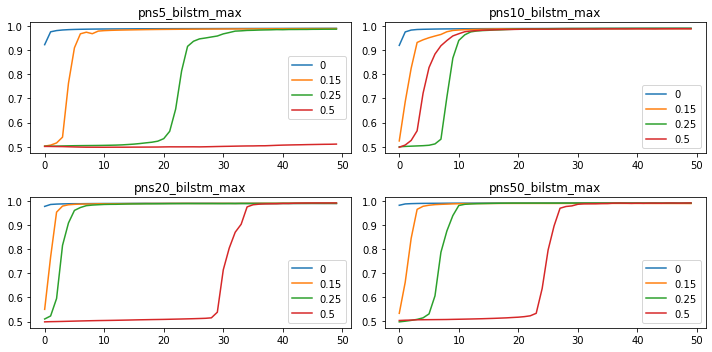

In [8]:
plot_roc_auc_score([pns5_bilstm_max, pns10_bilstm_max, pns20_bilstm_max, pns50_bilstm_max], 
                   ['pns5_bilstm_max', 'pns10_bilstm_max', 'pns20_bilstm_max', 'pns50_bilstm_max']
)

Максимум сделал ситуацию сильно лучше, на нижних графиках наблюдается то, что хочется видеть: нет обучения в минус и установлен правильный порядок. Однако, на правом верхнем графике модель с ```PCLS``` $ = 0.5$ снова повела себя странно - она начала сходиться раньше чем модель с ```PCLS``` $ = 0.25$. Возможно, максимум слишком категоричен, у нужно плавнее аггегировать вектора на скрытом слое. Есть предположение, что в этом случае сможет помочь плоский ```attention```, который будет взвешивать фичи векторов скрытого слоя.

На данный момент двунаправленная ```LSTM``` с аггрегацией по максимуму это лучшее, что удалось получить в попытке избавиться от дефектов.

### Расчет метрик на датасете с негативными примерами

Сейчас есть результат для обычной плоской сетки, которая на датасете ленты дает высокий скор. Ее лучший результат на ```tsa_wos``` - $0.86$. Это не кажется удивительным, ведь если во время обучения сеть не видела ничего кроме новостей, то логично предположить, что столкнувшись с художественным стилем или публицистикой, у нее могут возникнуть проблемы, ведь контекст в разных стилях текстов будет отличаться. 

Еще можно предположить что модели, которые понижают размерность контекста, будут более гибкими при обучении и дадут лучший результат чем плоская сетка. Но если результат будет по-прежнему не высок, то наверно стоит собрать датасет с более полным набор стилей.

Цель — получить результат на ```tsa_wos``` для других моделей, обученных на ленте. Выбраны следующие модели с ```PNS``` $ = 10$, и ```PCLS``` $ = 0.25$:

* Обычная ```LSTM```, дефекты которой исследовались в этом ноутбуке
* Двунаправленная ```LSTM``` с аггрегацией по максимуму
* ```LSTM``` с  трехмерным ```attention```
* Плоский ```attention```


Остальные настройки обучения совпадают с теми, которые указаны в начале ноутбука.

| PlainNetwork | LSTMNetwork | BidirectLSTMNetwork | AttentionReccurentNetwork | AttentionNetwork
| :-: | :-: | :-: | :-: | :-: |
| 0.86 | ... | 0.88 | 0.83 | 0.77 |

In [5]:
! ls -l

total 2308
-rw-rw-r-- 1 dabdya dabdya  406542 окт 14 13:15 AttentionAffect.ipynb
drwxrwxr-x 2 dabdya dabdya    4096 окт 14 00:35 images
drwxrwxr-x 2 dabdya dabdya    4096 окт 14 00:19 scores
drwxrwxr-x 2 dabdya dabdya    4096 окт 14 12:25 tasks
-rw-rw-r-- 1 dabdya dabdya 1939323 окт  8 00:01 tsa_wos.parquet


In [6]:
TASK_PATH = "tasks"
os.listdir(TASK_PATH)

['lstm_attention.pickle',
 'attention_2d.pickle',
 'lstm.pickle',
 'bilstm_max.pickle']

In [7]:
import pickle

tasks = dict()

for model_filename in os.listdir(TASK_PATH):
    with open(f"{TASK_PATH}/{model_filename}", "rb") as f:
        variable_name = model_filename.split('.')[0]
        tasks[variable_name] = pickle.load(f)

In [8]:
from tg.grammar_ru.ml.tasks.tsa import TsaAlgorithm
from yo_fluq_ds import FileIO

In [50]:
words = FileIO.read_json('../../research/tsa/words.json')
only_pymorphy = False
borderline = 0.5

In [43]:
algs = {
    task_name: TsaAlgorithm(task_obj, words, borderline, only_pymorphy)
    for task_name, task_obj in tasks.items()
}

In [2]:
rdf_test = pd.read_parquet("datasets/tsa_wos.parquet")
rdf_test.head()

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,sid,file_id,corpus_id,original_corpus_id,is_target,label,reference_sentence_id,reference_word_index,original_word_id,original_sentence_id,original_paragraph_id,updated
0,0,0,0,0,1,Поэтому,ru,7,6b79d1df6a5a6fc7c49faefc6cd62cb0/13,6a59d89a-8043-41ec-8751-242988c1de6a,wos.tsa.zip,wos.src.zip,False,0,0,-1,0,0,0,False
1,1,0,1,0,1,помимо,ru,6,6b79d1df6a5a6fc7c49faefc6cd62cb0/13,6a59d89a-8043-41ec-8751-242988c1de6a,wos.tsa.zip,wos.src.zip,False,0,0,-1,1,0,0,False
2,2,0,2,0,1,идеи,ru,4,6b79d1df6a5a6fc7c49faefc6cd62cb0/13,6a59d89a-8043-41ec-8751-242988c1de6a,wos.tsa.zip,wos.src.zip,False,0,0,-1,2,0,0,False
3,3,0,3,0,0,“,punct,1,6b79d1df6a5a6fc7c49faefc6cd62cb0/13,6a59d89a-8043-41ec-8751-242988c1de6a,wos.tsa.zip,wos.src.zip,False,0,0,-1,3,0,0,False
4,4,0,4,0,1,давайте,ru,7,6b79d1df6a5a6fc7c49faefc6cd62cb0/13,6a59d89a-8043-41ec-8751-242988c1de6a,wos.tsa.zip,wos.src.zip,False,0,0,-1,4,0,0,False


In [45]:
algs

{'lstm_attention': <tg.grammar_ru.ml.tasks.tsa.algorithm.TsaAlgorithm at 0x7fbe4c9d5220>,
 'attention_2d': <tg.grammar_ru.ml.tasks.tsa.algorithm.TsaAlgorithm at 0x7fbe4c9d5820>,
 'lstm': <tg.grammar_ru.ml.tasks.tsa.algorithm.TsaAlgorithm at 0x7fbe4c9d5340>,
 'bilstm_max': <tg.grammar_ru.ml.tasks.tsa.algorithm.TsaAlgorithm at 0x7fbe4c9d5e20>}

С обычной ```LSTM``` багнул, забыл у нее убрать двунаправленность, поэтому предикт падает. Надо заново переобучить, но кажется получить скор лучше чем у двунаправленной все равно не получится.

In [46]:
predictions = {
    task_name: alg._build_prediction_frame(rdf_test) 
    for task_name, alg in algs.items()
    if task_name != 'lstm'
}

2022-10-14 08:49:02.458270+00:00 INFO: prediction: 0/1
2022-10-14 08:50:05.241922+00:00 INFO: prediction: 0/1
2022-10-14 08:51:02.815830+00:00 INFO: prediction: 0/1


In [47]:
from sklearn.metrics import roc_auc_score

In [48]:
scores = {
    task_name: roc_auc_score(rdf_test.loc[df_pred.index].label, df_pred.predicted)
    for task_name, df_pred in predictions.items()
}

In [49]:
scores

{'lstm_attention': 0.8275377740387819,
 'attention_2d': 0.7650092456853468,
 'bilstm_max': 0.8841973745585394}

Недостаточно просто обучить разные виды ```LSTM``` на новостном датасете и сильно улучшить скор по сравнению с обычной плоской сеткой, двунаправленная ```LSTM``` с аггрегацией по максимуму дает скор $0.88$, но это лишь чуть лучше чем предыдущий максимум. Поэтому нужно собрать более полный датасет, который будет состоять в том числе и из художественных текстов, и публицистики, а затем вычислить метрики еще раз.